# Think Bayes

Copyright 2018 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# import classes from thinkbayes2
from thinkbayes import Pmf, Cdf, Suite, Joint

from thinkbayes import thinkplot

## Lions and Tigers and Bears

Suppose we visit a wild animal preserve where we know that the only animals are lions and tigers and bears, but we don't know how many of each there are.

During the tour, we see 3 lions, 2 tigers and one bear.  Assuming that every animal had an equal chance to appear in our sample, estimate the prevalence of each species.

What is the probability that the next animal we see is a bear?

### Grid algorithm

I'll start with a grid algorithm, enumerating the space of prevalences, `p1`, `p2`, and `p3`, that add up to 1, and computing the likelihood of the data for each triple of prevalences.

In [2]:
class LionsTigersBears(Suite, Joint):
    
    def Likelihood(self, data, hypo):
        """
        
        data: string 'L' , 'T', 'B'
        hypo: p1, p2, p3
        """
        # Fill this in.

In [3]:
# Solution

class LionsTigersBears(Suite, Joint):
    
    def Likelihood(self, data, hypo):
        """
        
        data: string 'L' , 'T', 'B'
        hypo: p1, p2, p3
        """
        p1, p2, p3 = hypo
        if data == 'L':
            return p1
        if data == 'T':
            return p2
        if data == 'B':
            return p3

In [4]:
ps = np.linspace(0, 1, 101);

Here's a simple way to find eligible triplets, but it is inefficient, and it runs into problems with floating-point approximations.

In [5]:
from itertools import product

def enumerate_triples(ps):
    for p1, p2, p3 in product(ps, ps, ps):
        if p1+p2+p3 == 1:
            yield p1, p2, p3

As an exercise, write a better version of `enumerate_triples`.

In [6]:
# Solution

from itertools import product

def enumerate_triples(ps):
    for p1, p2 in product(ps, ps):
        if p1 + p2 > 1:
            continue
        p3 = 1 - p1 - p2
        yield p1, p2, p3

Now we can initialize the suite.

In [7]:
suite = LionsTigersBears(enumerate_triples(ps));

Here are functions for displaying the distributions

In [8]:
def plot_marginal_pmfs(joint):
    pmf_lion = joint.Marginal(0)
    pmf_tiger = joint.Marginal(1)
    pmf_bear = joint.Marginal(2)

    thinkplot.Pdf(pmf_lion, label='lions')
    thinkplot.Pdf(pmf_tiger, label='tigers')
    thinkplot.Pdf(pmf_bear, label='bears')
    
    thinkplot.decorate(xlabel='Prevalence',
                       ylabel='PMF')

In [9]:
def plot_marginal_cdfs(joint):
    pmf_lion = joint.Marginal(0)
    pmf_tiger = joint.Marginal(1)
    pmf_bear = joint.Marginal(2)

    thinkplot.Cdf(pmf_lion.MakeCdf(), label='lions')
    thinkplot.Cdf(pmf_tiger.MakeCdf(), label='tigers')
    thinkplot.Cdf(pmf_bear.MakeCdf(), label='bears')
    
    thinkplot.decorate(xlabel='Prevalence',
                       ylabel='CDF')

Here are the prior distributions

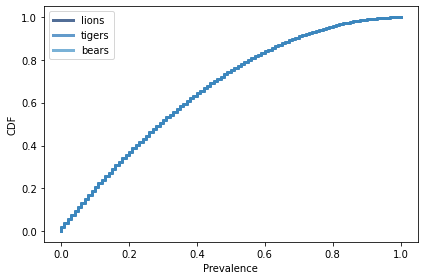

In [10]:
plot_marginal_cdfs(suite)

Now we can do the update.

In [11]:
for data in 'LLLTTB':
    suite.Update(data)

And here are the posteriors.

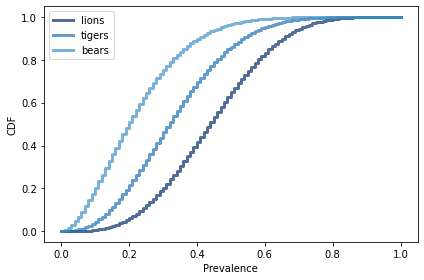

In [12]:
plot_marginal_cdfs(suite)

To get the predictive probability of a bear, we can take the mean of the posterior marginal distribution:

In [13]:
suite.Marginal(2).Mean()

0.22232592246925062

Or we can do a pseudo-update and use the total probability of the data.

In [14]:
suite.Copy().Update('B')

0.22232592246925043

### Using the Dirichlet object

The Dirichlet distribution is the conjugate prior for this likelihood function, so we can use the `Dirichlet` object to do the update.

The following is a [monkey patch](https://en.wikipedia.org/wiki/Monkey_patch) that gives `Dirichlet` objects a `Marginal` method.

In [16]:
from thinkbayes import Dirichlet

def DirichletMarginal(dirichlet, i):
    return dirichlet.MarginalBeta(i).MakePmf()

Dirichlet.Marginal = DirichletMarginal

Here are the priors:

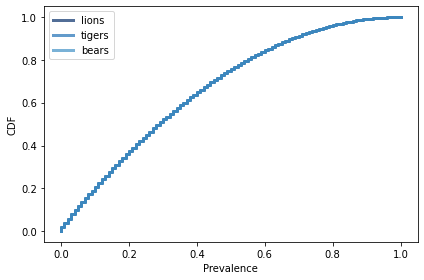

In [17]:
dirichlet = Dirichlet(3)
plot_marginal_cdfs(dirichlet)

Here's the update.

In [18]:
dirichlet.Update((3, 2, 1))

Here are the posterior PDFs.

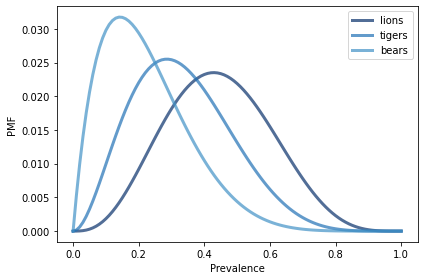

In [19]:
plot_marginal_pmfs(dirichlet)

And the CDFs.

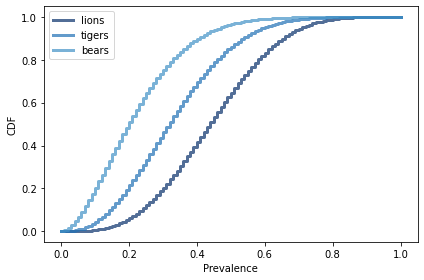

In [20]:
plot_marginal_cdfs(dirichlet)

And we can confirm that we get the same results as the grid algorithm.

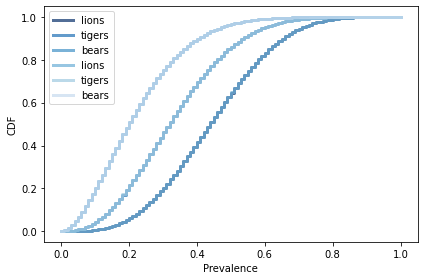

In [21]:
thinkplot.PrePlot(6)
plot_marginal_cdfs(dirichlet)
plot_marginal_cdfs(suite)

### MCMC

Exercise: Implement this model using MCMC.  You might want to start with [this example](http://christianherta.de/lehre/dataScience/bayesian/Multinomial-Dirichlet.slides.php).

In [22]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

import pymc3 as pm

/home/thom/venv38/lib/python3.8/site-packages/theano/gof/op.py:1543: SyntaxWarning: 'str' object is not callable; perhaps you missed a comma?
  define_macros.append("#define INPUT_%d %s" (i, inp))
/home/thom/venv38/lib/python3.8/site-packages/theano/gof/op.py:1547: SyntaxWarning: 'str' object is not callable; perhaps you missed a comma?
  define_macros.append("#define OUTPUT_%d %s" (i, inp))
/home/thom/venv38/lib/python3.8/site-packages/theano/gof/opt.py:1287: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if len(tracks) is 0:
/home/thom/venv38/lib/python3.8/site-packages/theano/compile/mode.py:264: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if optimizer is 'default':
/home/thom/venv38/lib/python3.8/site-packages/theano/tensor/nnet/bn.py:645: SyntaxWarning: "is" with a literal. Did you mean "=="?
  return [theano.gradient.DisconnectedType()() if r is 0 else r


Here's the data.

In [23]:
observed = [0,0,0,1,1,2]
k = len(Pmf(observed))
a = np.ones(k)

array([1., 1., 1.])

Here's the MCMC model:

In [24]:
# Solution

model = pm.Model()

with model:
    ps = pm.Dirichlet('ps', a, shape=a.shape)
    xs = pm.Categorical('xs', ps, observed=observed, shape=1)
    
model

In [25]:
# Solution

with model:
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(1000, start=start, step=step, tune=1000)

logp = -5.8985, ||grad|| = 1.118: 100%|██████████| 7/7 [00:00<00:00, 1096.67it/s]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:01<00:00, 5931.31draws/s]


Check the traceplot

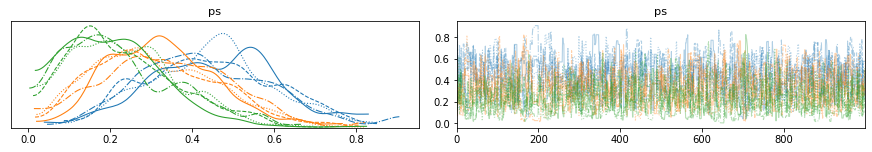

In [26]:
pm.traceplot(trace);

And let's see the results.

In [27]:
def plot_trace_cdfs(trace):
    rows = trace['ps'].transpose()

    cdf_lion = Cdf(rows[0])
    cdf_tiger = Cdf(rows[1])
    cdf_bear = Cdf(rows[2])

    thinkplot.Cdf(cdf_lion, label='lions')
    thinkplot.Cdf(cdf_tiger, label='tigers')
    thinkplot.Cdf(cdf_bear, label='bears')
    
    thinkplot.decorate(xlabel='Prevalence',
                       ylabel='CDF')

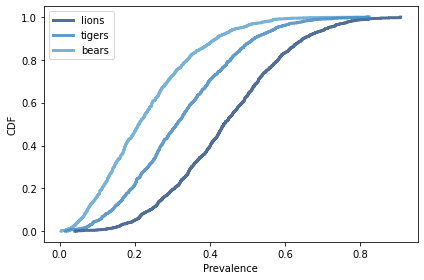

In [28]:
plot_trace_cdfs(trace)

And compare them to what we got with Dirichlet:

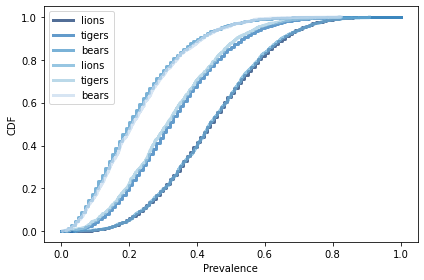

In [29]:
thinkplot.PrePlot(6)
plot_marginal_cdfs(dirichlet)
plot_trace_cdfs(trace)

### Using a Multinomial distribution

Here's another solution that uses a Multinomial distribution instead of a Categorical.  In this case, we represent the observed data using just the counts, `[3, 2, 1]`, rather than a specific sequence of observations `[0,0,0,1,1,2]`.

I suspect that this is a better option; because it uses a less specific representation of the data (without losing any information), I would expect the probability space to be easier to search.

This solution is based on [this excellent notebook](http://nbviewer.jupyter.org/github/WillKoehrsen/probabilistic-programming/blob/master/Allen%20Downey%20Problem.ipynb) from Will Koehrsen.

In [30]:
animals = ['lions', 'tigers', 'bears']
c = np.array([3, 2, 1])
a = np.array([1, 1, 1])

array([1, 1, 1])

In [31]:
warnings.simplefilter('ignore', UserWarning)

with pm.Model() as model:
    # Probabilities for each species
    ps = pm.Dirichlet('ps', a=a, shape=3)
    # Observed data is a multinomial distribution with 6 trials
    xs = pm.Multinomial('xs', n=6, p=ps, shape=3, observed=c)   

In [32]:
model

In [33]:
with model:
    # Sample from the posterior
    trace = pm.sample(draws=1000, tune=1000)

Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:02<00:00, 3376.23draws/s]


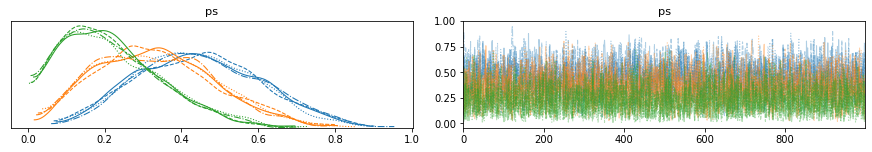

In [34]:
pm.traceplot(trace);

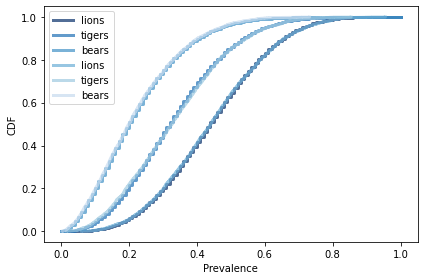

In [35]:
thinkplot.PrePlot(6)
plot_marginal_cdfs(dirichlet)
plot_trace_cdfs(trace)

The results look good.  We can use `summary` to get the posterior means, and other summary stats.

In [36]:
summary = pm.summary(trace)
summary.index = animals
summary

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
lions,0.445,0.159,0.144,0.733,0.003,0.002,3175.0,3080.0,3135.0,2597.0,1.0
tigers,0.335,0.153,0.073,0.618,0.003,0.002,3585.0,3332.0,3598.0,2905.0,1.0
bears,0.220,0.130,0.009,0.455,0.002,0.002,2994.0,2748.0,3073.0,2823.0,1.0


We can also use `plot_posterior` to get a better view of the results.

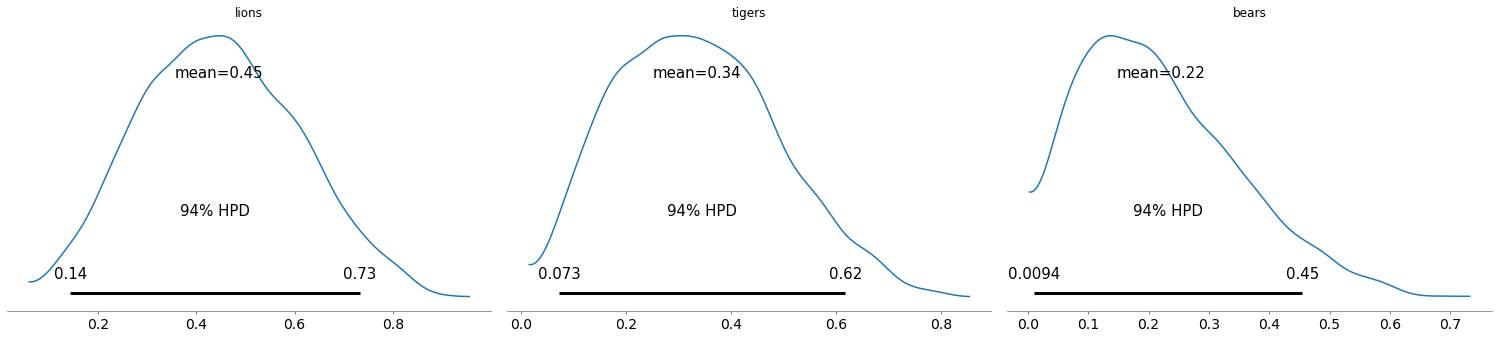

In [37]:
ax = pm.plot_posterior(trace, varnames = ['ps']);

for i, a in enumerate(animals):
    ax[i].set_title(a)